In [ ]:
# 꿀팀 : 퇴직 예측을 할때는 랜포는 별로고, 라이트GBM 성능이 좋았다.

In [63]:
# PACKAGE_BASIC
import pandas as pd
import numpy as np

# PACKAGE_VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns 

# PACKAGE_PREPROCESSING
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# PACKAGE_MODELING
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# PACKAGE_EVALUATION
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import log_loss

In [105]:
# OPTION_JUPYTER
pd.set_option('display.max_columns', 1050)
pd.set_option('display.width', 1000)

In [66]:
# LOAD dataset 
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample = pd.read_csv('./data/sample_submission.csv')

train['fiberID'] = train['fiberID'].astype(str)
test['fiberID'] = test['fiberID'].astype(str)

In [4]:
# FUNCTION : 독립변수별 histogram 그리기
def draw_distplot(df):
    fig, ax = plt.subplots(6, 3, figsize=(36,36))

    sns.distplot(df['psfMag_u'], ax=ax[0][0])
    sns.distplot(df['fiberMag_u'], ax=ax[0][1])
    sns.distplot(df['petroMag_u'], ax=ax[0][2])

    sns.distplot(df['psfMag_g'], ax=ax[1][0])
    sns.distplot(df['fiberMag_g'], ax=ax[1][1])
    sns.distplot(df['petroMag_g'], ax=ax[1][2])

    sns.distplot(df['psfMag_r'], ax=ax[2][0])
    sns.distplot(df['fiberMag_r'], ax=ax[2][1])
    sns.distplot(df['petroMag_r'], ax=ax[2][2])

    sns.distplot(df['psfMag_i'], ax=ax[3][0])
    sns.distplot(df['fiberMag_i'], ax=ax[3][1])
    sns.distplot(df['petroMag_i'], ax=ax[3][2])

    sns.distplot(df['psfMag_z'], ax=ax[4][0])
    sns.distplot(df['fiberMag_z'], ax=ax[4][1])
    sns.distplot(df['petroMag_z'], ax=ax[4][2])

    sns.distplot(df['fiberID'], ax=ax[5][0])
    sns.barplot(x=df['type'].value_counts().index, y=df['type'].value_counts(), ax=ax[5][1])

    plt.tight_layout()
    plt.show()

In [5]:
# FUNCTION : pearson 상관관계 분석을 위한 heatmap 그리기
def draw_corr_heatmap(df):
    plt.figure(figsize=(15,12))
    corr = df.corr(method='pearson')
    sns.heatmap(data = corr, annot=True, fmt = '.2f', linewidths=.5, cmap='RdYlBu_r')
    plt.show()

In [6]:
# FUNCTION : 두 변수간 scatter map 그리기
def draw_scattermap(df, x, y):
    plt.figure(figsize=(10,10))
    sns.scatterplot(x=x, y=y, s=10, hue='type', data=df)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [65]:
# FUNCTION : 각 독립변수의 OUTLIER 제거
def remove_outlier(df, column):
    df_d = df
    fraud_column_data = df[column]
    q_25 = np.percentile(fraud_column_data.values, 25)
    q_75 = np.percentile(fraud_column_data.values, 75)
    
    lqr = (q_75-q_25) * 1.5
    lowest = q_25 - lqr
    highest = q_75 + lqr
    outlier_idx = fraud_column_data[(fraud_column_data < lowest)|(fraud_column_data > highest)].index
    df_d.drop(outlier_idx, axis=0, inplace=True)
    
    print('target : ' + column + ' / 제거된 row수 : ' + str(len(outlier_idx)) + ' / 결과 row수 : ' + str(df_d.shape))
    return df_d

def remove_outlier2(df, column, target):
    df_d = df
    fraud_column_data = df.loc[df['type'] == target][column]
    q_25 = np.percentile(fraud_column_data.values, 25)
    q_75 = np.percentile(fraud_column_data.values, 75)
    
    lqr = (q_75-q_25) * 1.5
    lowest = q_25 - lqr
    highest = q_75 + lqr
    outlier_idx = fraud_column_data[(fraud_column_data < lowest)|(fraud_column_data > highest)].index
    df_d.drop(outlier_idx, axis=0, inplace=True)
    
    print('target : ' + column + ' / 제거된 row수 : ' + str(len(outlier_idx)) + ' / 결과 row수 : ' + str(df_d.shape))
    return df_d

In [112]:
def fiberIDXtoDummy(train_df, test_df):
    train_dum = pd.get_dummies(train_df['fiberID'])
    train_df_s = pd.merge(train_df, train_dum, left_index=True, right_index=True, how='left')
    
    test_dum = pd.get_dummies(test_df['fiberID'])
    test_df_s = pd.merge(test_df, test_dum, left_index=True, right_index=True, how='left')
    
    for fibID in list(train_df_s['fiberID'].unique()):
        if fibID not in test_dum:
            test_df_s[fibID] = 0
            
    train_df_s = train_df_s.drop(['fiberID'], axis=1)
    test_df_s = test_df_s.drop(['fiberID', 'type'], axis=1)
    return train_df_s, test_df_s

def startoDummy(train_df, test_df):
    train_dum = pd.get_dummies(train_df['fiberID'])
    train_df_s = pd.merge(train_df, train_dum, left_index=True, right_index=True, how='left')
    
    test_dum = pd.get_dummies(test_df['fiberID'])
    test_df_s = pd.merge(test_df, test_dum, left_index=True, right_index=True, how='left')
    
    for star_type in list(train_df_s['type'].unique()):
        if star_type not in test_dum:
            test_df_s[star_type] = 0
            
    train_df_s = train_df_s.drop(['fiberID'], axis=1)
    test_df_s = test_df_s.drop(['fiberID'], axis=1)
    return train_df_s, test_df_s

In [8]:
# FUNCTION : 모델 훈련 예측
def train_model(classifier, X, Y):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1, stratify = Y)
    
    classifier.fit(x_train, y_train)
    
    y_train_pred = classifier.predict(x_train)
    y_test_pred = classifier.predict(x_test)
    
    evaluate_pred('train data', y_train, y_train_pred)
    evaluate_pred('test data' ,y_test, y_test_pred)
    
    return classifier

In [9]:
# FUNCTION : 모델에 대한 정확도 출력
def evaluate_pred(title, y, y_pred):
    accuracy =  accuracy_score(y, y_pred)
    precision =  precision_score(y, y_pred, average='macro')
    recall =  recall_score(y, y_pred, average='macro')
    # f1 =  f1_score(y, y_pred, average='macro')
    # roc = roc_auc_score(y, y_pred, average='macro')
    print('--------------+' + str(title) + '+--------------')
    print('정확도 : {0:.3f}, 정밀도 : {1:.3f}, 재현율 : {2:.3f}'.format(accuracy, precision, recall))
    # print('f1-score : {0:.3f}, auc : {1:.3f}').format(f1, roc)

In [11]:
# FUNCTION : 실제 예측하고 결과물 만들기
def test_model(classifier, X):
    
    Y_pred = classifier.predict(X)
    
    return Y_pred

In [ ]:
# make RESULT to SUBMIT CSV FILE
def sync_col_train_test(df):
    df = df[['id','type']]
    result = pd.get_dummies(df, prefix='', prefix_sep='')
    
    for star_type in list(train['type'].unique()):
        if star_type not in result:
            result[star_type] = 0
    
    result = result[['id', 'STAR_WHITE_DWARF', 'STAR_CATY_VAR', 'STAR_BROWN_DWARF', 'SERENDIPITY_RED', 'REDDEN_STD', 'STAR_BHB', 'GALAXY', 'SERENDIPITY_DISTANT', 'QSO', 'SKY', 'STAR_RED_DWARF', 'ROSAT_D', 'STAR_PN', 'SERENDIPITY_FIRST', 'STAR_CARBON', 'SPECTROPHOTO_STD', 'STAR_SUB_DWARF', 'SERENDIPITY_MANUAL', 'SERENDIPITY_BLUE']]
    result.to_csv('./data/submit.csv', sep=',', index=False)
    
    return result

In [47]:
# make RESULT to SUBMIT CSV FILE
def make_CSV(df):
    df = df[['id','type']]
    result = pd.get_dummies(df, prefix='', prefix_sep='')
    
    for star_type in list(train['type'].unique()):
        if star_type not in result:
            result[star_type] = 0
    
    result = result[['id', 'STAR_WHITE_DWARF', 'STAR_CATY_VAR', 'STAR_BROWN_DWARF', 'SERENDIPITY_RED', 'REDDEN_STD', 'STAR_BHB', 'GALAXY', 'SERENDIPITY_DISTANT', 'QSO', 'SKY', 'STAR_RED_DWARF', 'ROSAT_D', 'STAR_PN', 'SERENDIPITY_FIRST', 'STAR_CARBON', 'SPECTROPHOTO_STD', 'STAR_SUB_DWARF', 'SERENDIPITY_MANUAL', 'SERENDIPITY_BLUE']]
    result.to_csv('./data/submit.csv', sep=',', index=False)
    
    return result

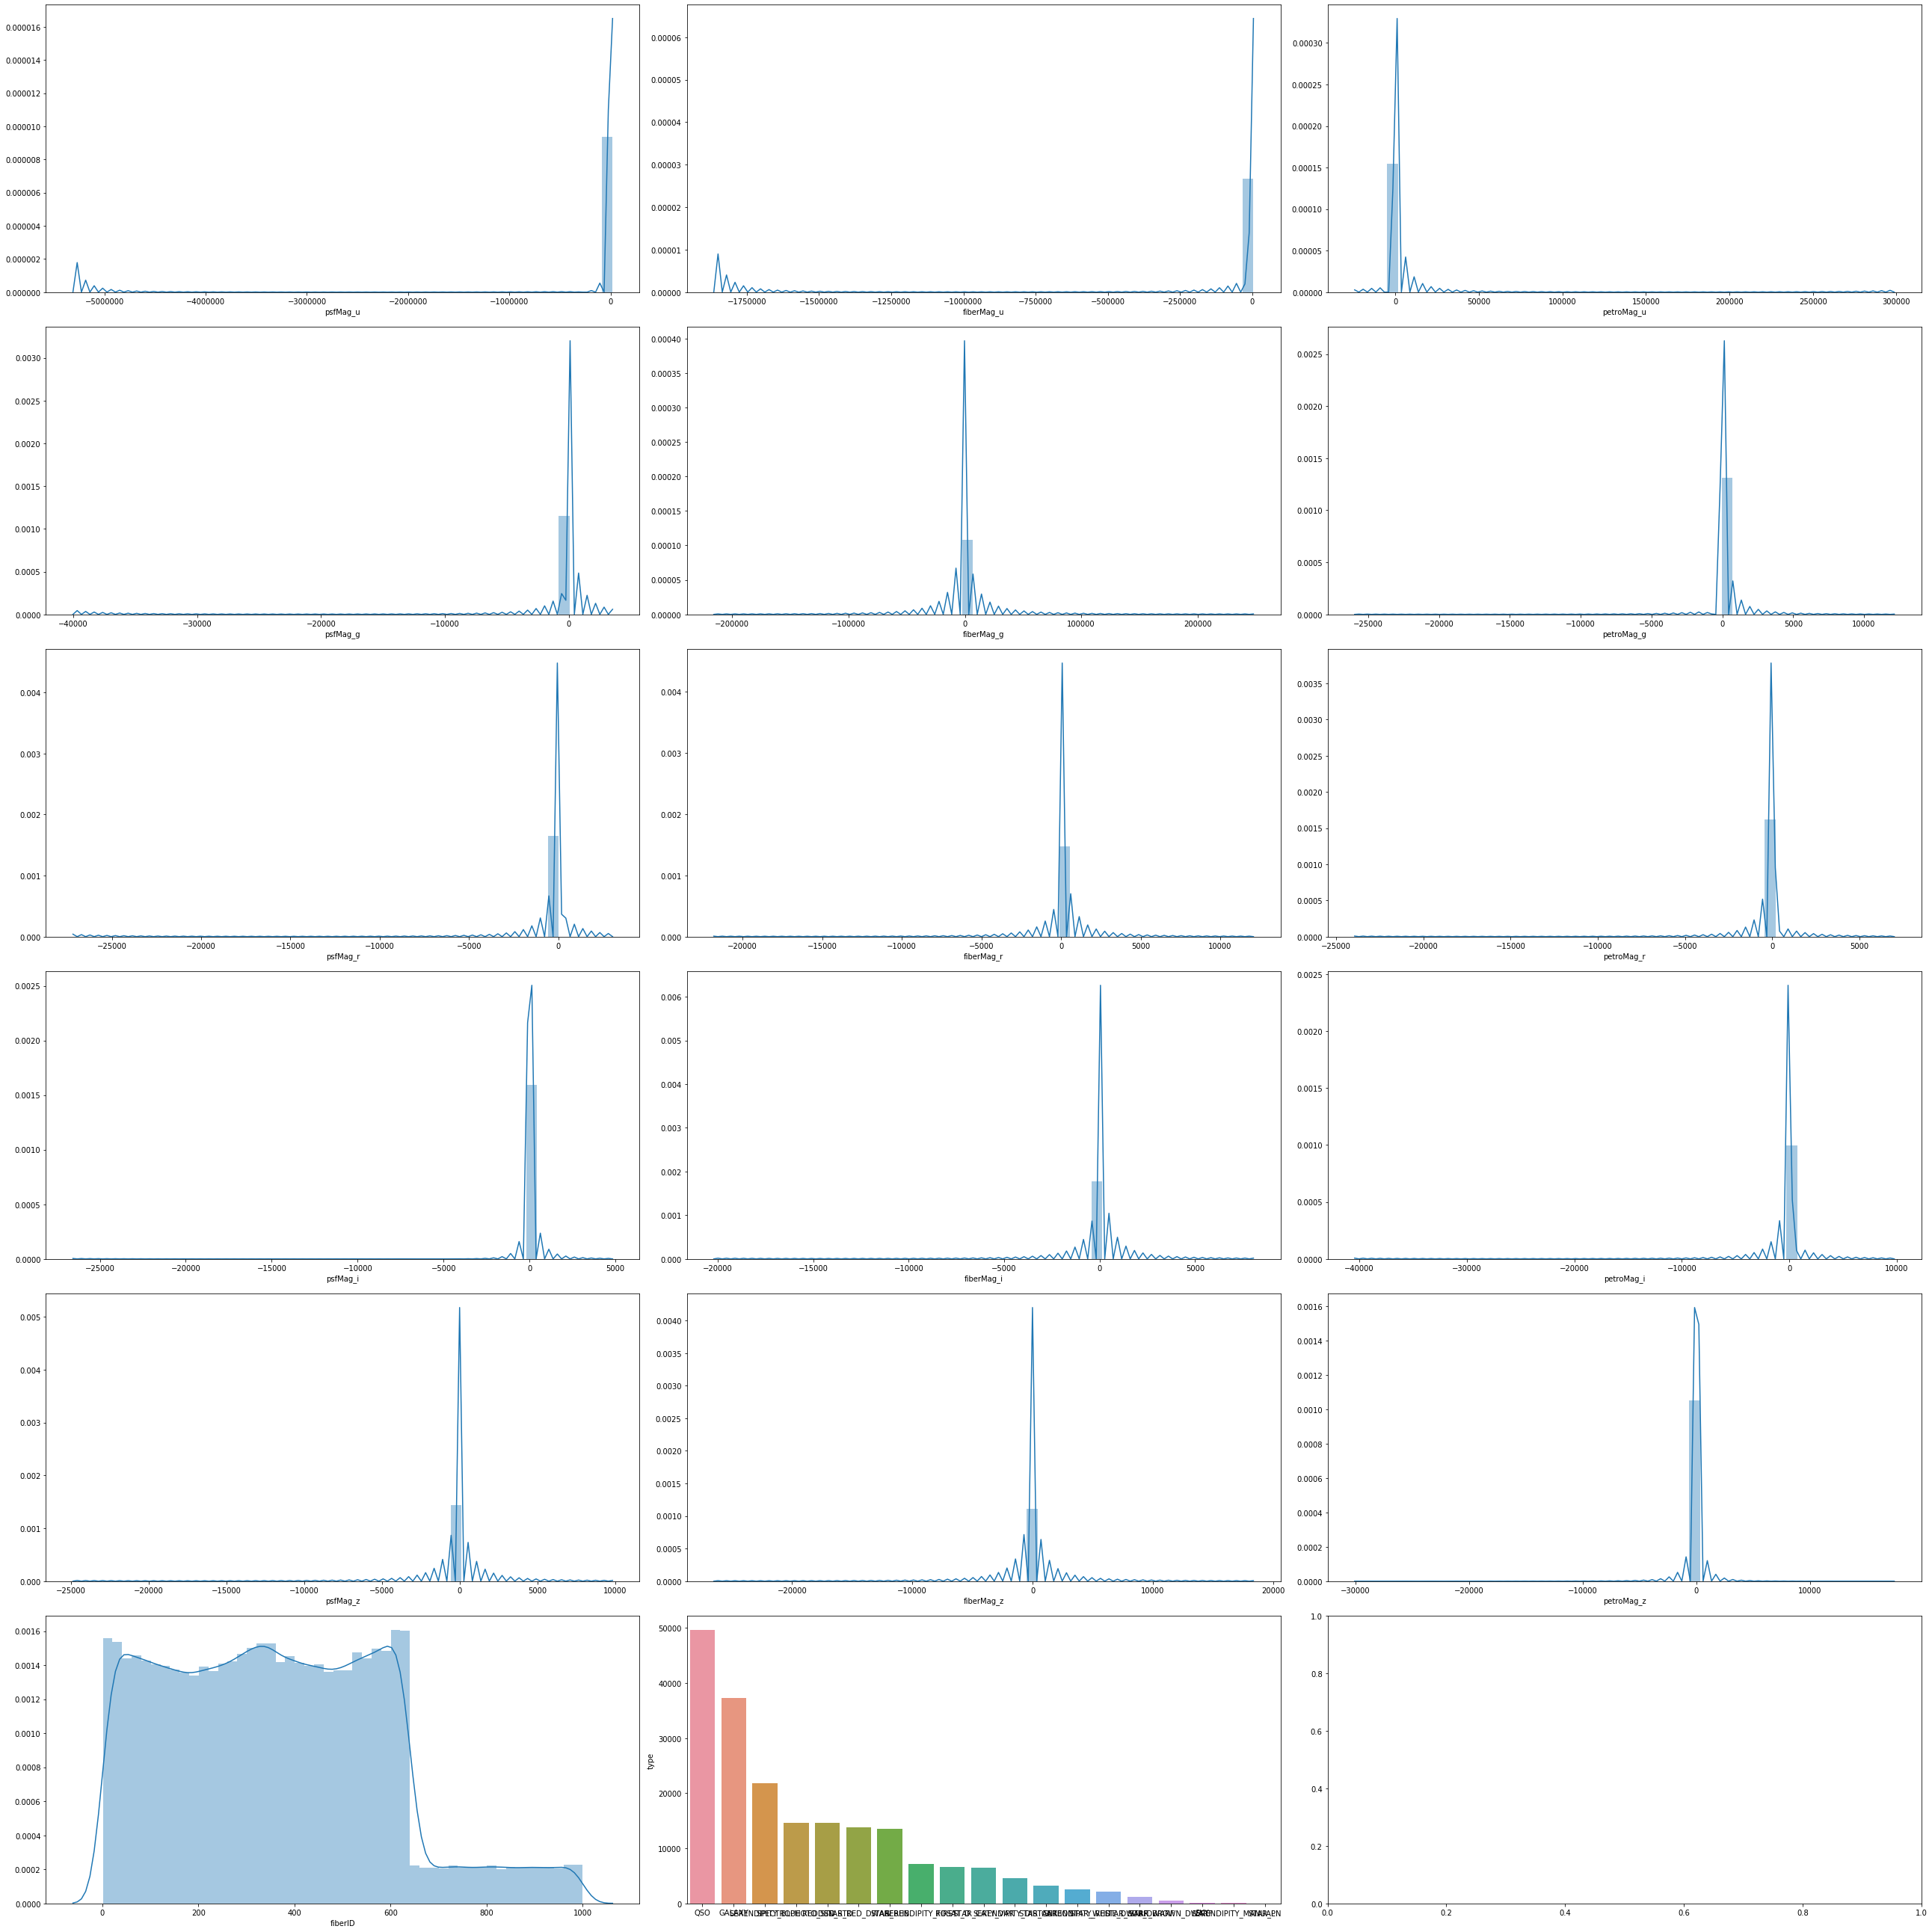

In [13]:
# 1. 변수들의 HISTOGRAM을 통해 분포 확인하기
draw_distplot(train)

In [ ]:
# 변수 별 상관관계 확인하기
draw_corr_heatmap(train)

In [ ]:
# 강한 상관관계를 가진 petroMag_u-psfMag_u / fiberMag_u-psfMag_u / fiberMag_u-petroMag_u 의 scatter map 보기
draw_scattermap(train, 'petroMag_u', 'psfMag_u')
draw_scattermap(train, 'fiberMag_u', 'psfMag_u')
draw_scattermap(train, 'petroMag_u', 'fiberMag_u')

In [68]:
# 각 변수별 이상치 제거하기
train_R = train
train_R = remove_outlier(train_R, 'psfMag_u')
train_R = remove_outlier(train_R, 'psfMag_g')
train_R = remove_outlier(train_R, 'psfMag_r')
train_R = remove_outlier(train_R, 'psfMag_i')
train_R = remove_outlier(train_R, 'psfMag_z')

train_R = remove_outlier(train_R, 'fiberMag_u')
train_R = remove_outlier(train_R, 'fiberMag_g')
train_R = remove_outlier(train_R, 'fiberMag_r')
train_R = remove_outlier(train_R, 'fiberMag_i')
train_R = remove_outlier(train_R, 'fiberMag_z')

train_R = remove_outlier(train_R, 'petroMag_u')
train_R = remove_outlier(train_R, 'petroMag_g')
train_R = remove_outlier(train_R, 'petroMag_r')
train_R = remove_outlier(train_R, 'petroMag_i')
train_R = remove_outlier(train_R, 'petroMag_z')

train_R = remove_outlier(train_R, 'modelMag_u')
train_R = remove_outlier(train_R, 'modelMag_g')
train_R = remove_outlier(train_R, 'modelMag_r')
train_R = remove_outlier(train_R, 'modelMag_i')
train_R = remove_outlier(train_R, 'modelMag_z')

target : psfMag_u / 제거된 row수 : 2909 / 결과 row수 : (197082, 23)
target : psfMag_g / 제거된 row수 : 1368 / 결과 row수 : (195714, 23)
target : psfMag_r / 제거된 row수 : 208 / 결과 row수 : (195506, 23)
target : psfMag_i / 제거된 row수 : 86 / 결과 row수 : (195420, 23)
target : psfMag_z / 제거된 row수 : 191 / 결과 row수 : (195229, 23)
target : fiberMag_u / 제거된 row수 : 2368 / 결과 row수 : (192861, 23)
target : fiberMag_g / 제거된 row수 : 519 / 결과 row수 : (192342, 23)
target : fiberMag_r / 제거된 row수 : 50 / 결과 row수 : (192292, 23)
target : fiberMag_i / 제거된 row수 : 12 / 결과 row수 : (192280, 23)
target : fiberMag_z / 제거된 row수 : 104 / 결과 row수 : (192176, 23)
target : petroMag_u / 제거된 row수 : 7611 / 결과 row수 : (184565, 23)
target : petroMag_g / 제거된 row수 : 723 / 결과 row수 : (183842, 23)
target : petroMag_r / 제거된 row수 : 92 / 결과 row수 : (183750, 23)
target : petroMag_i / 제거된 row수 : 252 / 결과 row수 : (183498, 23)
target : petroMag_z / 제거된 row수 : 1042 / 결과 row수 : (182456, 23)
target : modelMag_u / 제거된 row수 : 2741 / 결과 row수 : (179715, 23)
target : modelMa

In [113]:
train_discrete, test_discrete = fiberIDXtoDummy(train_R, test)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

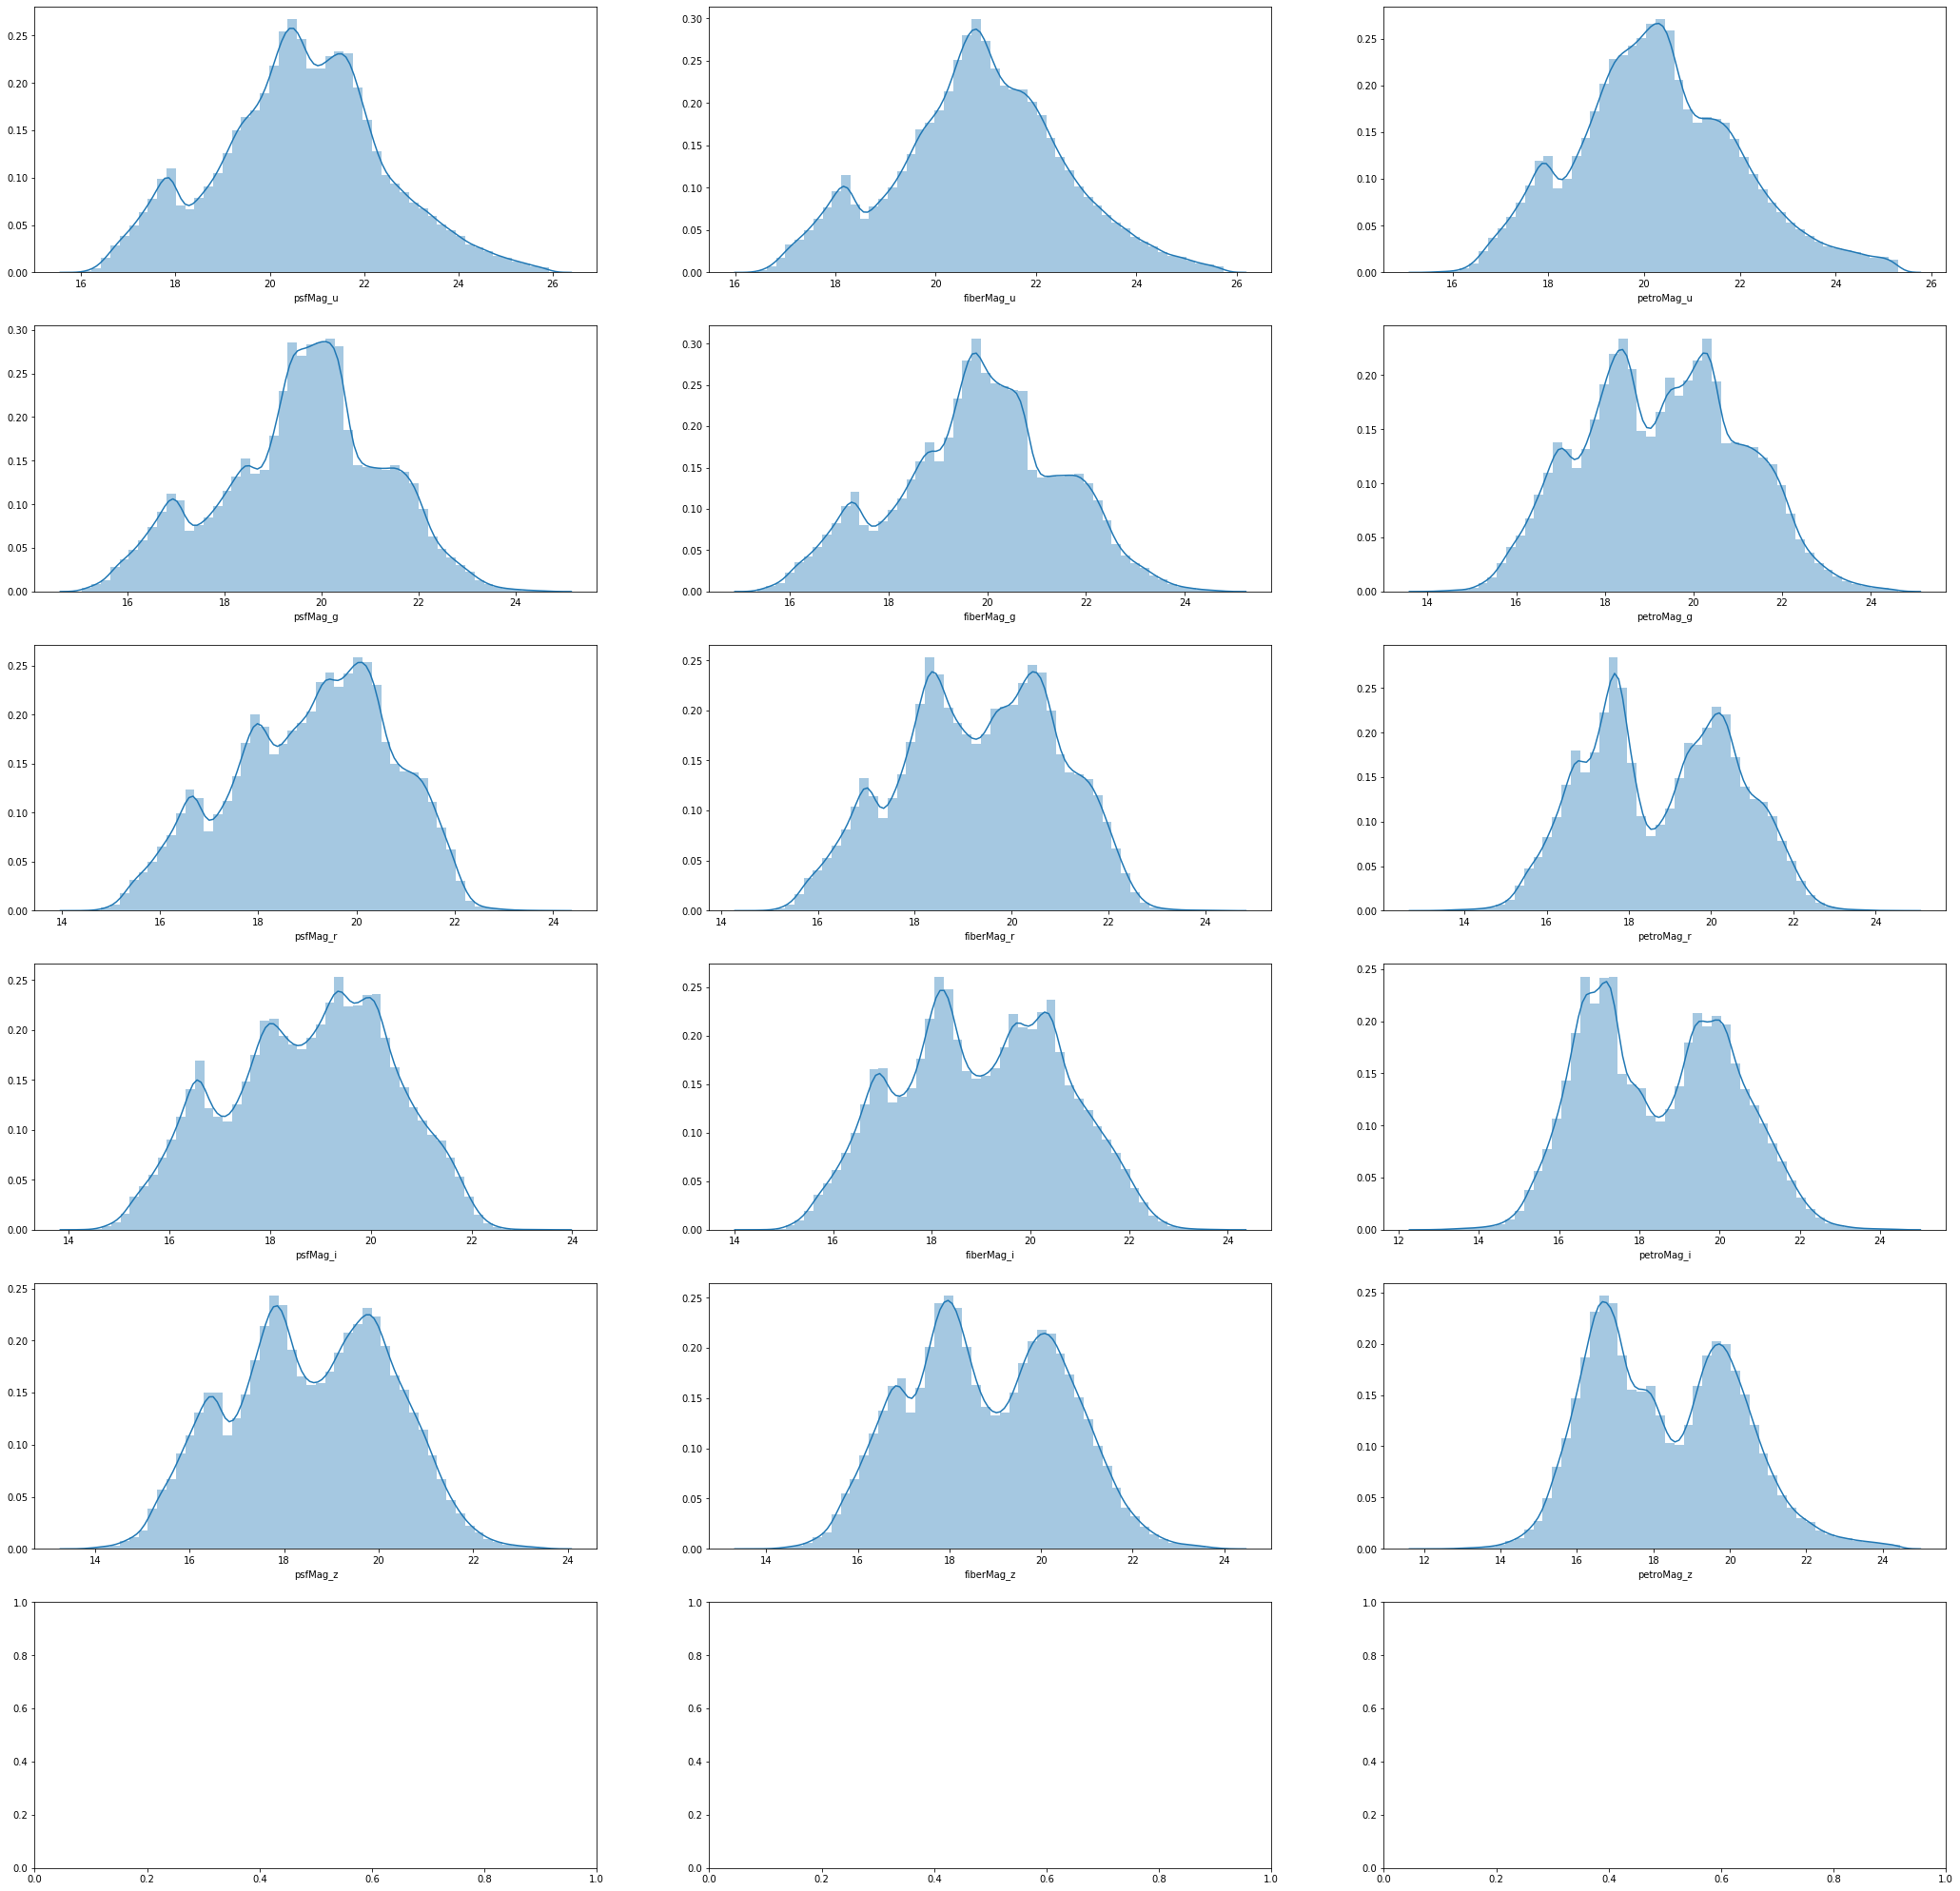

In [69]:
# 이상치 제거 후 Histogram
draw_distplot(train_R)

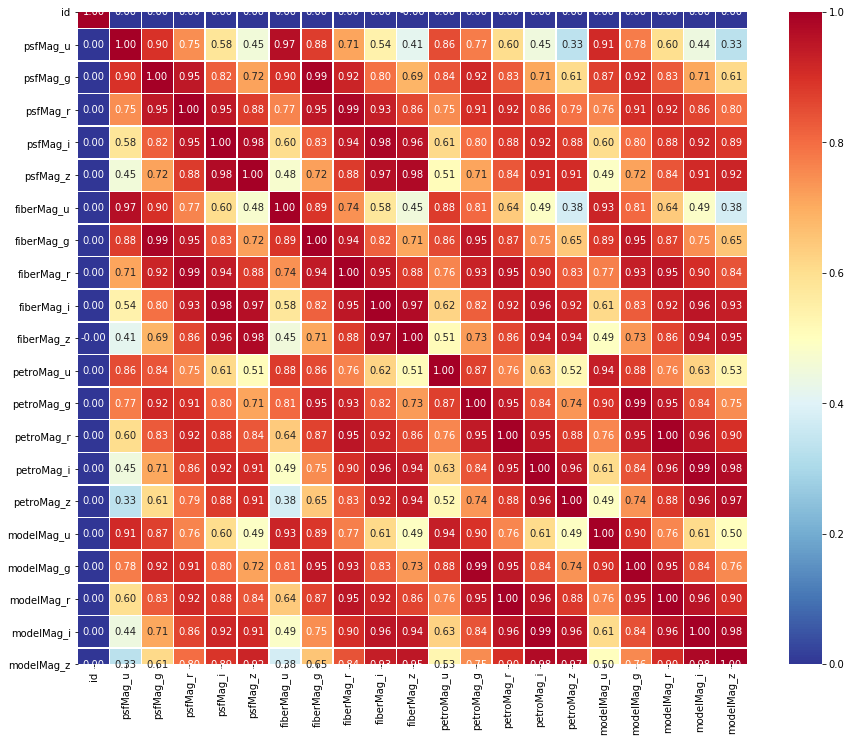

In [74]:
# 변수 별 상관관계 확인하기
draw_corr_heatmap(train_R)

In [ ]:
draw_scattermap(train_R, 'fiberMag_g', 'psfMag_g') # 상관관계가 매우 높은 두개(0.99)
draw_scattermap(train_R, 'petroMag_z', 'psfMag_u') # 상관관계가 매우 낮은 두개(0.33)

In [114]:
# X = train_R[['fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z']]
# Y = train_R['type']
# X = train[['fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z']]
# Y = train['type']

X = train_discrete.drop(['id','type'], axis=1)
Y = train_discrete['type']

In [89]:
model_tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=12)
model_tree = train_model(model_tree, X, Y)

--------------+train data+--------------
정확도 : 0.880, 정밀도 : 0.868, 재현율 : 0.769


C:\Users\LGCNS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------+test data+--------------
정확도 : 0.836, 정밀도 : 0.627, 재현율 : 0.627


In [115]:
model_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
model_forest = train_model(model_forest, X, Y)

--------------+train data+--------------
정확도 : 0.991, 정밀도 : 0.993, 재현율 : 0.980


C:\Users\LGCNS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------+test data+--------------
정확도 : 0.852, 정밀도 : 0.642, 재현율 : 0.610


In [56]:
model_tree_for_ada = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=12)
model_ada = AdaBoostClassifier(base_estimator=model_tree_for_ada, n_estimators=10, learning_rate=0.1, random_state=1)
model_ada = train_model(model_ada, X, Y)

--------------+train data+--------------
정확도 : 0.940, 정밀도 : 0.947, 재현율 : 0.929


C:\Users\LGCNS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------+test data+--------------
정확도 : 0.863, 정밀도 : 0.727, 재현율 : 0.685


In [116]:
test_discrete

,id,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,1,10,100,1000,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,129,13,130,131,132,133,134,135,136,137,138,139,14,140,141,142,143,144,145,146,147,148,149,15,150,151,152,153,154,155,156,157,158,159,16,160,161,162,163,164,165,166,167,168,169,17,170,171,172,173,174,175,176,177,178,179,18,180,181,182,183,184,185,186,187,188,189,19,190,191,192,193,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,291,292,293,294,295,296,297,298,299,3,30,300,301,302,303,304,305,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,346,347,348,349,35,350,351,352,353,354,355,356,357,358,359,36,360,361,362,363,364,365,366,367,368,369,37,370,371,372,373,374,375,376,377,378,379,38,380,381,382,383,384,385,386,387,388,389,39,390,391,392,393,394,395,396,397,398,399,4,40,400,401,402,403,404,405,406,407,408,409,41,410,411,412,413,414,415,416,417,418,419,42,420,421,422,423,424,425,426,427,428,429,43,430,431,432,433,434,435,436,437,438,439,44,440,441,442,443,444,445,446,447,448,449,45,450,451,452,453,454,455,456,457,458,459,46,460,461,462,463,464,465,466,467,468,469,47,470,471,472,473,474,475,476,477,478,479,48,480,481,482,483,484,485,486,487,488,489,49,490,491,492,493,494,495,496,497,498,499,5,50,500,501,502,503,504,505,506,507,508,509,51,510,511,512,513,514,515,516,517,518,519,52,520,521,522,523,524,525,526,527,528,529,53,530,531,532,533,534,535,536,537,538,539,54,540,541,542,543,544,545,546,547,548,549,55,550,551,552,553,554,555,556,557,558,559,56,560,561,562,563,564,565,566,567,568,569,57,570,571,572,573,574,575,576,577,578,579,58,580,581,582,583,584,585,586,587,588,589,59,590,591,592,593,594,595,596,597,598,599,6,60,600,601,602,603,604,605,606,607,608,609,61,610,611,612,613,614,615,616,617,618,619,62,620,621,622,623,624,625,626,627,628,629,63,630,631,632,633,634,635,636,637,638,639,64,640,642,643,644,646,647,648,649,65,650,651,652,653,654,655,656,657,658,66,660,661,662,663,664,665,666,667,668,669,67,670,671,672,674,676,677,678,679,68,680,681,682,683,684,686,687,688,69,690,692,694,695,696,698,7,70,700,702,704,705,706,707,708,709,71,712,714,716,718,719,72,720,721,722,723,724,726,728,729,73,730,731,732,734,735,736,737,738,739,74,740,742,743,744,746,747,748,75,750,751,752,754,756,758,76,760,762,763,764,765,766,768,77,770,771,772,773,774,775,776,777,778,779,78,780,781,782,784,785,786,788,789,79,790,791,792,794,795,796,798,8,80,800,802,803,804,805,806,807,808,809,81,810,811,812,814,816,818,819,82,820,821,822,823,824,825,826,828,83,830,834,835,836,837,838,84,840,841,842,843,844,846,848,849,85,850,852,853,854,856,858,859,86,860,862,863,864,865,866,868,87,870,871,872,873,874,875,876,877,878,879,88,882,883,884,886,888,89,890,892,893,894,895,896,897,898,899,9,90,900,902,904,906,907,908,91,910,911,912,913,914,915,916,918,919,92,920,922,923,924,926,928,929,93,930,932,934,935,936,937,938,939,94,940,941,942,943,944,946,947,948,949,95,950,951,952,953,954,955,956,957,958,96,960,962,964,965,966,968,969,97,970,971,972,974,975,976,977,978,979,98,980,982,984,985,987,988,989,99,990,991,992,993,994,995,998,999,767,885,685,996,903,827,733,901,959,745,931,761,817,905,675,839,797,973,793,755,832,880,713,715,699,887,717,749,697,783,659,881,641,967,693,725,889,759,645,851,867,833,981,741,921,757,945,983,813,710,927,861,925,829,8

In [117]:
# 실제 테스트셋에 적용하여 제출용 파일 생성
tX = test_discrete.drop(['id'], axis=1)
tY = test_model(model_forest, tX)
submit = test
submit['type'] = tY
res = make_CSV(submit)

In [118]:
res
# tY = test_model(model_forest, tX)

,id,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
0,199991,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,199992,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,199993,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,199994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,199995,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10004,209995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10005,209996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10006,209997,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10007,209998,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_nIDX = train_NoutL_t.drop(['id','type'], axis=1)
train_nIDX['fiberID'] = train_nIDX['fiberID'].astype(str)
train_ohe = pd.get_dummies(train_nIDX, prefix='', prefix_sep='')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [ ]:
from sklearn.metrics import log_loss

log_loss(y_test, y_test_pred, eps=1e-15)